## Benchmarking task - Q-A/RAG

#### Install python packages requested by benchmarking

If you have not install the requested python libraries, uncomment the following command to run the installation.

In [1]:
#!pip install -r ../peccyben/requirements.txt

#### Import libraries

In [2]:
import pandas as pd
import sys

sys.path.insert(0, '../')

from peccyben.qaragtask import QA_Ben, QA_Create_VDB
from peccyben.utils import Ben_Save
from peccyben.promptcatalog import Prompt_Template_Gen

2025-04-01 22:03:07.749849: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-01 22:03:07.763364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-01 22:03:07.782167: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-01 22:03:07.787967: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-01 22:03:07.801147: I tensorflow/core/platform/cpu_feature_guar

#### Configuration

Setup your environment parameters 

* **BENCH_KEY**: a unique keyname for your benchmarking in this round 
* **S3_BUCKET**: the S3 buckt you created for the benchmarking    
* **TASK_FOLDER**: the task folder you created under the S3 bucket   
* **INPUT_FILE**: the file name of the dataset you prepared for benchmarking
* **DOC_FILE**: the document to query 
* **VDB_NAME**: the vector db name for RAG pipeline   
* **METRICS_LIST**: the metrics we provide for the question-answer task    
* **BEDROCK_REGION**: the AWS region that the model benchmarking runs on Bedrock
* **COST_FILE**: the price file used for calculating model inference cost      

In [3]:
BENCH_KEY = 'PeccyBen_202503_test'
S3_BUCKET = 'genai-sdo-llm-ben-20240310'
TASK_FOLDER = 'ben-qa'
INPUT_FILE = 'cuad_test_50p.csv'
DOC_FILE = 'PACIRA_PHARMACEUTICALS_AGREEMENT.PDF'
VDB_NAME = "loha"
METRICS_LIST = ['Inference_Time','Input_Token','Output_Token','Throughput','RougeL-sum','Semantic_Similarity','BERT-F1','Toxicity',
                                            'Answer_Correctness','Answer_similarity','Answer_Relevancy','Context_Recall','Context_Precision','Cost','Cache_Input_Token','Cache_Output_Token']
BEDROCK_REGION = 'us-west-2'
COST_FILE = 'bedrock_od_public.csv'

Results_qa = pd.DataFrame()
Results_qa = Results_qa.assign(metric_name=METRICS_LIST) 
Results_qa = Results_qa.set_index('metric_name')

#### Create a vector DB for RAG pipeline

You can skip this step if you already created a vector db in the previous round of benchmarking

* Embedding model: here we use Titan text embedding model on Bedrock
* Set the chunk size and overlap size for your retriever embedding
* Invoke **QA_Create_VDB** to create a faiss vector store

In [4]:
import boto3
import botocore
from langchain.embeddings import BedrockEmbeddings

boto3_bedrock = boto3.client(service_name="bedrock", region_name="us-east-1")
boto3_bedrock_runtime = boto3.client(service_name="bedrock-runtime", region_name="us-east-1")

# Create embedding
bedrock_embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v2:0", client=boto3_bedrock_runtime)

/tmp/ipykernel_6470/926391637.py:9: LangChainDeprecationWarning: The class `BedrockEmbeddings` was deprecated in LangChain 0.2.11 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-aws package and should be used instead. To use it run `pip install -U :class:`~langchain-aws` and import as `from :class:`~langchain_aws import BedrockEmbeddings``.
  bedrock_embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v2:0", client=boto3_bedrock_runtime)


In [5]:
# Set chunk size and create the vector db
chunk_size = 1000
chunk_overlap = 100

QA_Create_VDB(chunk_size,chunk_overlap,bedrock_embeddings,VDB_NAME,S3_BUCKET,DOC_FILE,TASK_FOLDER)

#### Task specific setting

* Configure your **prompt** in the prompt catalog (prompt_catalog.json), and configure the prompt_catalog_id
* Set the **LLM hyperparameter** in model_kwargs. For the models on Bedrock, refer to [inferenceConfig](https://docs.aws.amazon.com/bedrock/latest/userguide/conversation-inference-call.html)
* Set **LLM-judge model** for RAGAS 

In [6]:
prompt_catalog_id = "qa-1"

model_kwargs = {
        'maxTokens': 1024, 
        'topP': 0.9, 
        'temperature': 0
}   
judge_model_id = "mistral.mistral-large-2402-v1:0"

#### Specify the model and other settings for benchmarking

Invoke **QA_Ben** function to conduct the benchmarking for one selected model, repeat for multiple models you want to benchmark

* **method**: set "Bedrock" for the models on Bedrock
* **region**: configured in the previous step
* **model_id**: specify the Model ID for the model endpoint
* **judge_model_id**: specify LLM-judge model for RAGAS
* **model_kwargs**: configured in previous step
* **prompt_template**: prompt template based on the prompt configured in previous step
* **s3_bucket**: configured in previous step
* **file_name**: configured in previous step
* **BENCH_KEY**: configured in previous step
* **task_folder**: configured in previous step
* **cost_key**: set "public" when using AWS public pricing to calculate the cost
* **save_id**: the model name displayed in the report 
* **SLEEP_SEC**: you can configure "sleep and retry" when throtting, for example, set SLEEP_SEC = 10 to wait for 10 seconds between each inference
* **SAMPLE_LEN**: you can configure the number of samples for inference
* **PP_TIME**: if you want to run model inference for multiple rounds, set the number of rounds here.  
* **cacheconf**: set "default" to enable Bedrock Prompt Caching in the inference, "None" to disable
* **latencyOpt**: set "optimized" to enable Bedrock Latency Optimized Inference, "None" to disable

In [7]:
# Claude 3.5 Haiku
model_id = "us.anthropic.claude-3-5-haiku-20241022-v1:0" 
save_id = 'Haiku-3.5'

prompt_template = Prompt_Template_Gen(model_id, prompt_catalog_id)
#print(prompt_template)

Results_qa[save_id] = QA_Ben(method="Bedrock",
                                   region=BEDROCK_REGION,
                                   model_id=model_id,
                                   judge_model_id=judge_model_id,                             
                                   model_kwargs=model_kwargs,
                                   prompt_template=prompt_template,
                                   vdb_name=VDB_NAME,
                                   s3_bucket=S3_BUCKET,
                                   file_name=INPUT_FILE,
                                   BENCH_KEY=BENCH_KEY,
                                   task_folder=TASK_FOLDER,
                                   cost_key=COST_FILE,
                                   save_id=save_id,
                                   SLEEP_SEC=5,SAMPLE_LEN=3,
                                   PP_TIME=1,
                                   cacheconf="None",latencyOpt="None")
Results_qa

0|what is the Exclusivity in this contract?


/home/sagemaker-user/peccyben_test_public/../peccyben/qaragtask.py:220: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question_org_list[i])


latency: 2.924
Input/output/total token: 2998 94 3092
Caching: 0 0
According to Section 3.13 of the contract, during the Term, PPI and its Affiliates are prohibited from:(i) filing for Marketing Authorization for any Competing Product in the Territory(ii) manufacturing any Competing Product in the Territory(iii) marketing any Competing Product in the Territory(iv) licensing any Third Party to do any of the above activities
1|what is the Termination For Convenience in this contract?
latency: 2.599
Input/output/total token: 3290 75 3365
Caching: 0 0
According to Section 16.3(b), EKR may terminate the Agreement for convenience at any time upon [**] ([**]) days prior written notice to PPI. This means EKR has the right to end the contract without specific cause, simply by providing advance notice as specified in the contract.
2|what is the Change Of Control in this contract?
latency: 4.527
Input/output/total token: 3055 187 3242
Caching: 0 0
According to Section 20.4, "Change of Control" is

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/sagemaker-user/peccyben_test_public/../peccyben/qaragtask.py:75: LangChainDeprecationWarning: The class `BedrockChat` was deprecated in LangChain 0.0.34 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-aws package and should be used instead. To use it run `pip install -U :class:`~langchain-aws` and import as `from :class:`~langchain_aws import ChatBedrock``.
  bedrock_model = BedrockChat(


Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[2]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[4]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[5]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[9]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[7]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[10]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[12]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[13]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[14]: TimeoutError()


,Haiku-3.5
metric_name,
Inference_Time,10.050000
Input_Token,9343.000000
Output_Token,356.000000
Throughput,102.312705
RougeL-sum,0.197698
Semantic_Similarity,0.566803
BERT-F1,0.847664
Toxicity,0.000605
Answer_Correctness,NaN


In [8]:
# nova-pro 
model_id = 'us.amazon.nova-pro-v1:0' 
save_id = 'nova-pro'

prompt_template = Prompt_Template_Gen(model_id, prompt_catalog_id)
#print(prompt_template)

Results_qa[save_id] = QA_Ben(method="Bedrock",
                                   region=BEDROCK_REGION,
                                   model_id=model_id,
                                   judge_model_id=judge_model_id,
                                   model_kwargs=model_kwargs,
                                   prompt_template=prompt_template,
                                   vdb_name=VDB_NAME,
                                   s3_bucket=S3_BUCKET,
                                   file_name=INPUT_FILE,
                                   BENCH_KEY=BENCH_KEY,
                                   task_folder=TASK_FOLDER,
                                   cost_key=COST_FILE,
                                   save_id=save_id,
                                   SLEEP_SEC=20,SAMPLE_LEN=3,
                                   PP_TIME=1,
                                   cacheconf="None",latencyOpt="None")
Results_qa

0|what is the Exclusivity in this contract?
latency: 1.458
Input/output/total token: 2993 85 3078
Caching: 0 0
During the Term, PPI and its Affiliates shall not: (i) file for Marketing Authorization with respect to any Competing Product in any country in the Territory, (ii) manufacture or have manufactured any Competing Product in any country in the Territory, (iii) market or have marketed any Competing Product in any country in the Territory or (iv) license any Third Party to do any of the foregoing.
1|what is the Termination For Convenience in this contract?
latency: 0.952
Input/output/total token: 3248 34 3282
Caching: 0 0
EKR may terminate this Agreement for convenience at any time upon [**] ([**]) days prior, written notice to PPI.
2|what is the Change Of Control in this contract?
latency: 1.742
Input/output/total token: 3035 118 3153
Caching: 0 0
Change of Control refers to a situation where either party's control is transferred to a third party that markets or sells a Competing 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[4]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[8]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[14]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[2]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[7]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[9]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[10]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[13]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[12]: TimeoutError()


,Haiku-3.5,nova-pro
metric_name,,
Inference_Time,10.050000,4.152000
Input_Token,9343.000000,9276.000000
Output_Token,356.000000,237.000000
Throughput,102.312705,161.751557
RougeL-sum,0.197698,0.229504
Semantic_Similarity,0.566803,0.526428
BERT-F1,0.847664,0.836060
Toxicity,0.000605,0.000590
Answer_Correctness,NaN,NaN


In [9]:
# Claude 3.5v2 Sonnet
model_id = 'us.anthropic.claude-3-5-sonnet-20241022-v2:0' 
save_id = 'Sonnet-3.5v2'

prompt_template = Prompt_Template_Gen(model_id, prompt_catalog_id)
#print(prompt_template)

Results_qa[save_id] = QA_Ben(method="Bedrock",
                                   region=BEDROCK_REGION,
                                   model_id=model_id,
                                   judge_model_id=judge_model_id,                             
                                   model_kwargs=model_kwargs,
                                   prompt_template=prompt_template,
                                   vdb_name=VDB_NAME,
                                   s3_bucket=S3_BUCKET,
                                   file_name=INPUT_FILE,
                                   BENCH_KEY=BENCH_KEY,
                                   task_folder=TASK_FOLDER,
                                   cost_key=COST_FILE,
                                   save_id=save_id,
                                   SLEEP_SEC=20,SAMPLE_LEN=3,
                                   PP_TIME=1,
                                   cacheconf="None",latencyOpt="None")
Results_qa

0|what is the Exclusivity in this contract?
latency: 3.93
Input/output/total token: 2998 112 3110
Caching: 0 0
During the Term, PPI and its Affiliates:1. Cannot file for Marketing Authorization for any Competing Product in the Territory2. Cannot manufacture or have manufactured any Competing Product in the Territory3. Cannot market or have marketed any Competing Product in the Territory4. Cannot license any Third Party to do any of the aboveAdditionally, EKR must purchase all its Product requirements from PPI during the Term, except when PPI is unable to supply Products.
1|what is the Termination For Convenience in this contract?
latency: 2.982
Input/output/total token: 3290 61 3351
Caching: 0 0
According to Section 16.3(b), EKR may terminate this Agreement for convenience at any time by providing written notice to PPI. The notice period is redacted in the document (shown as [**] ([**]) days).
2|what is the Change Of Control in this contract?
latency: 5.902
Input/output/total token: 30

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[2]: ValueError(Error raised by bedrock service: An error occurred (ThrottlingException) when calling the InvokeModel operation (reached max retries: 4): Too many tokens, please wait before trying again.)
ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[4]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[5]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[7]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[9]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[10]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[12]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[13]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[14]: TimeoutError()


,Haiku-3.5,nova-pro,Sonnet-3.5v2
metric_name,,,
Inference_Time,10.050000,4.152000,12.814000
Input_Token,9343.000000,9276.000000,9343.000000
Output_Token,356.000000,237.000000,356.000000
Throughput,102.312705,161.751557,79.961236
RougeL-sum,0.197698,0.229504,0.196039
Semantic_Similarity,0.566803,0.526428,0.597826
BERT-F1,0.847664,0.836060,0.844705
Toxicity,0.000605,0.000590,0.000610
Answer_Correctness,NaN,NaN,NaN


#### Generate benchmarking report

Invoke **Ben_Save** function to generate your benchmarking report and cost-performance analysis, all the results are stored in S3 bucket

* **Results_qa**: the benchmarking results generated in previous step
* **S3_BUCKET**: configured in previous step
* **BENCH_KEY**: configured in previous step
* **TASK_FOLDER**: configured in previous step
* **perf_metric**: select the performance metric from the metrics list in the previous step, for cost-performance analysis, for example, to analyze the accuracy by semantic similarity score with cost, set "Semantic_Similarity".  
* **top_x**: set the top x number of models you want to run the cost-performance analysis 
* **TITLE**: specify a title for the reports and charts

/home/sagemaker-user/peccyben_test_public/../peccyben/utils.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(llm_list,rotation = 90)


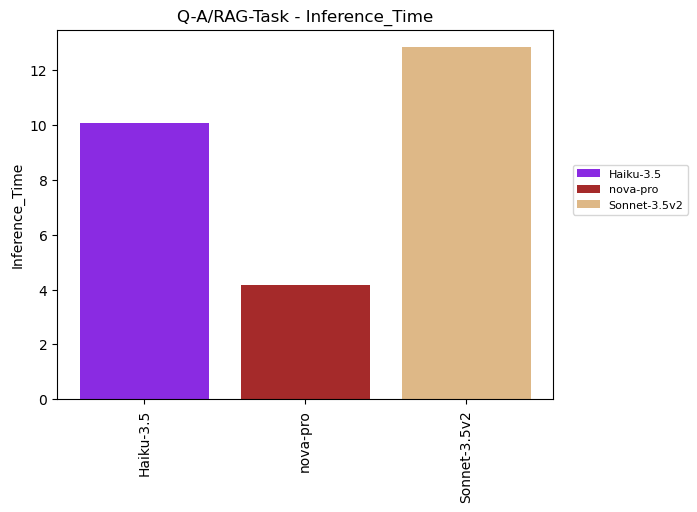

/home/sagemaker-user/peccyben_test_public/../peccyben/utils.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(llm_list,rotation = 90)


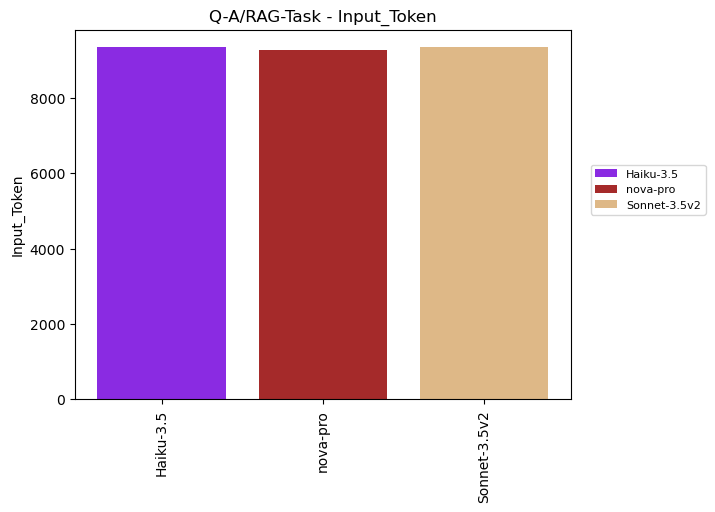

/home/sagemaker-user/peccyben_test_public/../peccyben/utils.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(llm_list,rotation = 90)


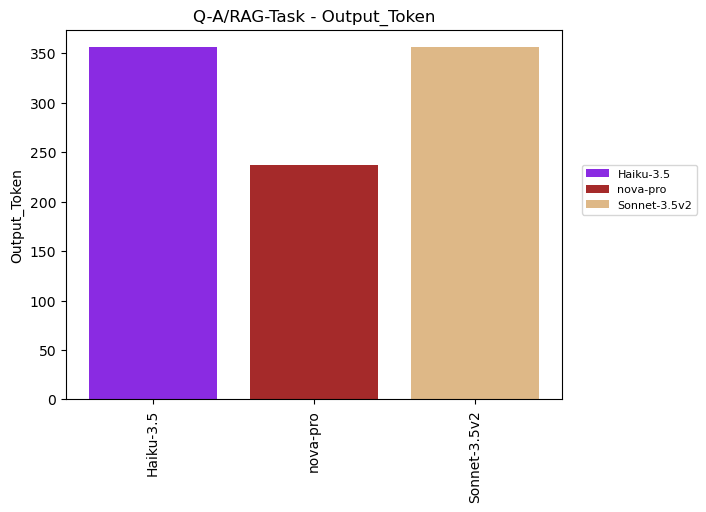

/home/sagemaker-user/peccyben_test_public/../peccyben/utils.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(llm_list,rotation = 90)


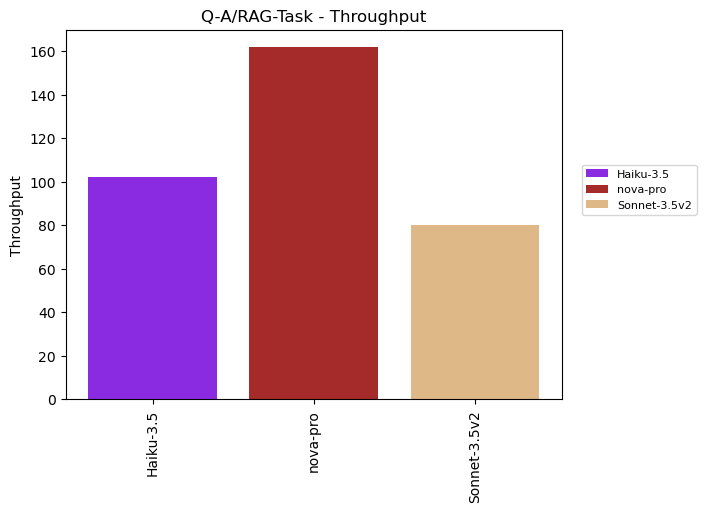

/home/sagemaker-user/peccyben_test_public/../peccyben/utils.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(llm_list,rotation = 90)


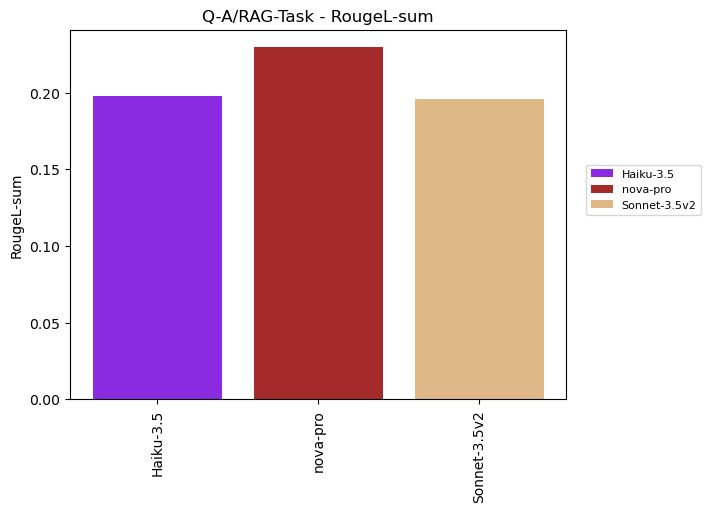

/home/sagemaker-user/peccyben_test_public/../peccyben/utils.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(llm_list,rotation = 90)


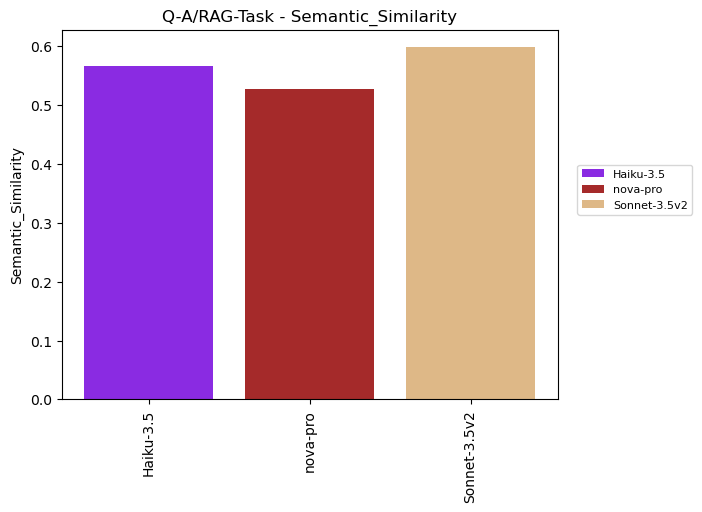

/home/sagemaker-user/peccyben_test_public/../peccyben/utils.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(llm_list,rotation = 90)


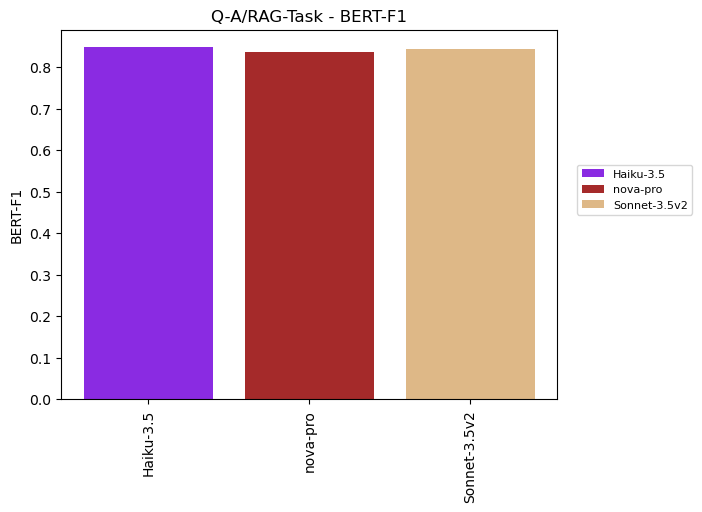

/home/sagemaker-user/peccyben_test_public/../peccyben/utils.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(llm_list,rotation = 90)


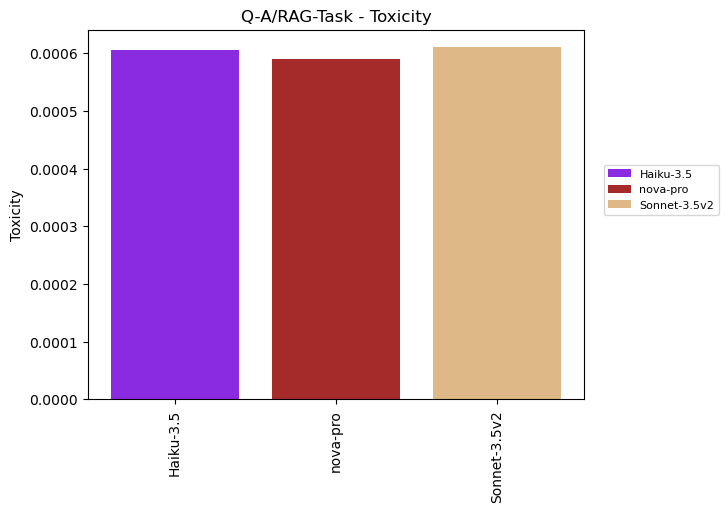

/home/sagemaker-user/peccyben_test_public/../peccyben/utils.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(llm_list,rotation = 90)


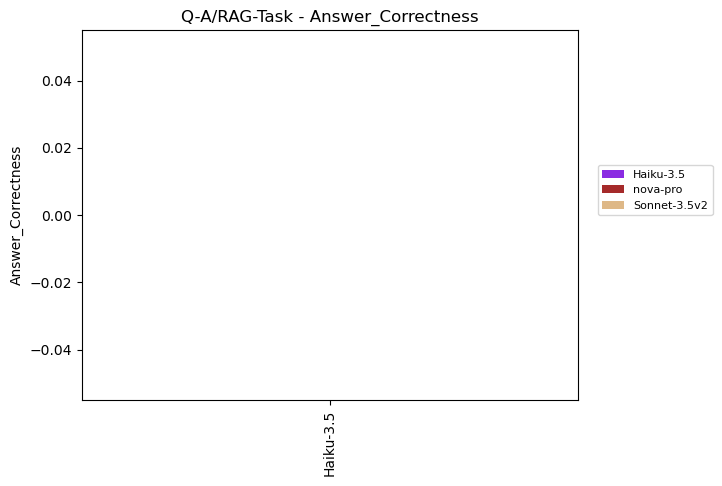

/home/sagemaker-user/peccyben_test_public/../peccyben/utils.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(llm_list,rotation = 90)


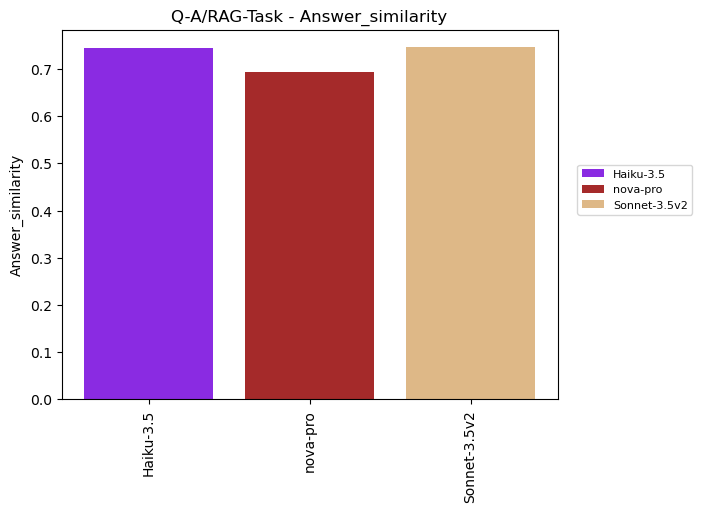

/home/sagemaker-user/peccyben_test_public/../peccyben/utils.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(llm_list,rotation = 90)


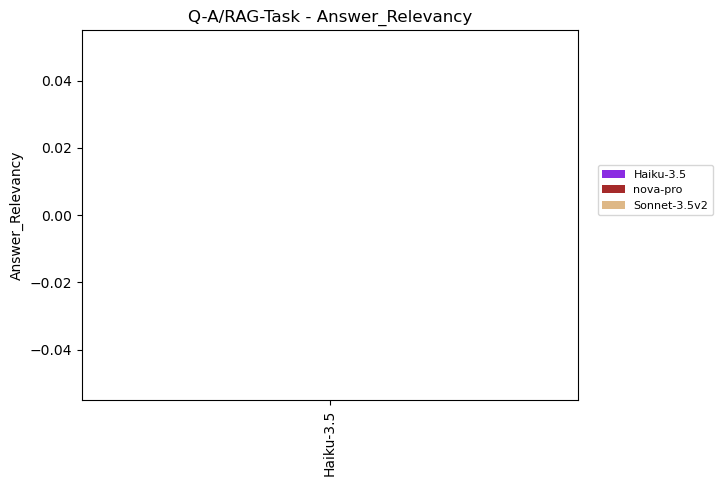

/home/sagemaker-user/peccyben_test_public/../peccyben/utils.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(llm_list,rotation = 90)


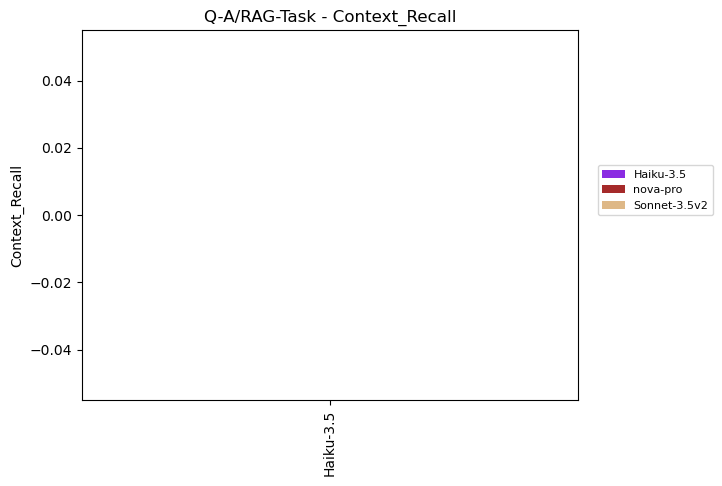

/home/sagemaker-user/peccyben_test_public/../peccyben/utils.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(llm_list,rotation = 90)


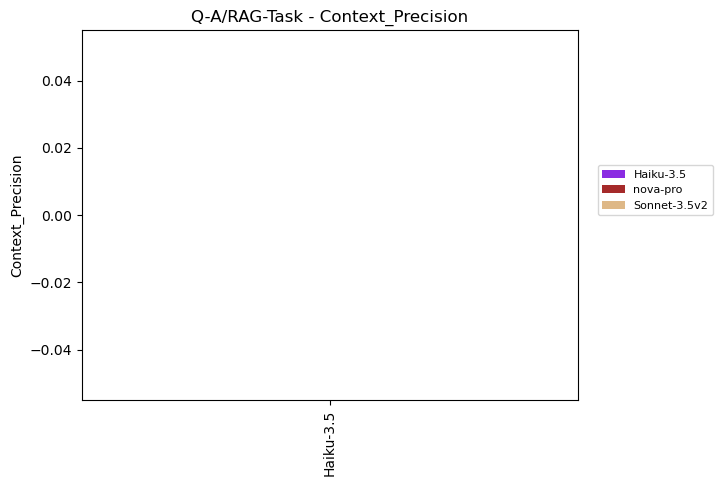

/home/sagemaker-user/peccyben_test_public/../peccyben/utils.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(llm_list,rotation = 90)


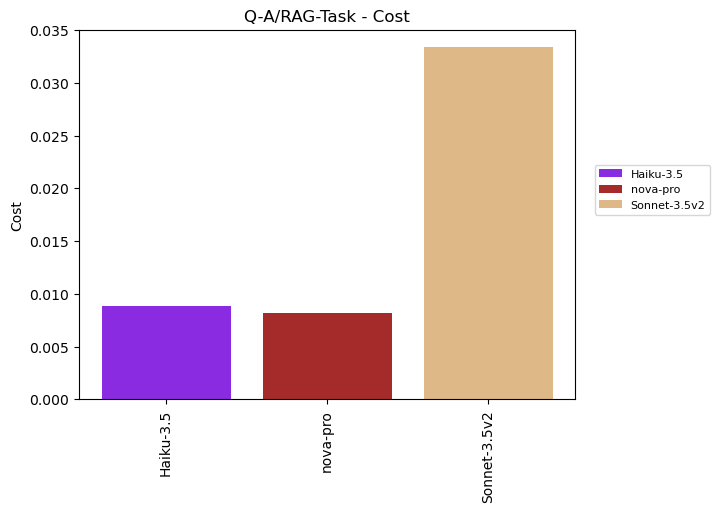

/home/sagemaker-user/peccyben_test_public/../peccyben/utils.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(llm_list,rotation = 90)


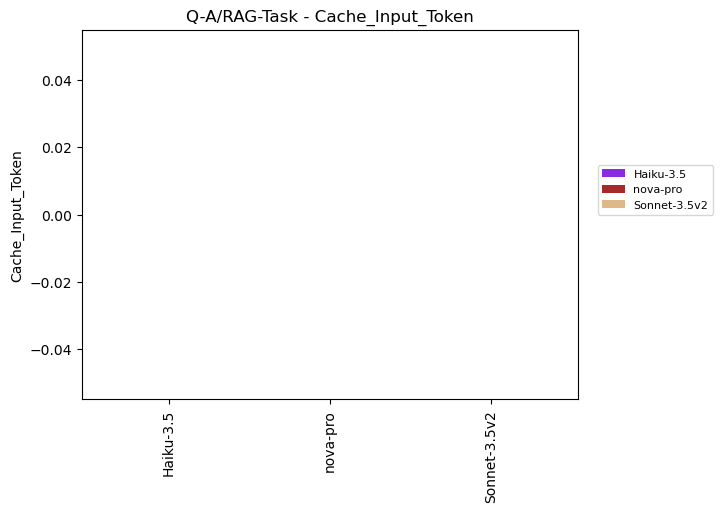

/home/sagemaker-user/peccyben_test_public/../peccyben/utils.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(llm_list,rotation = 90)


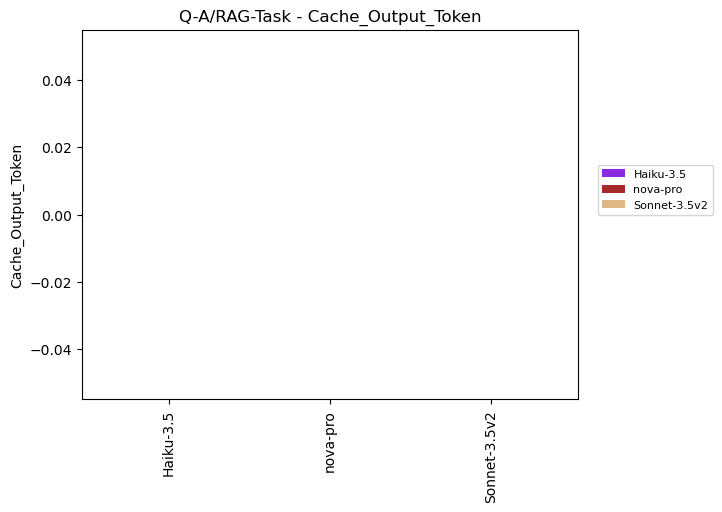

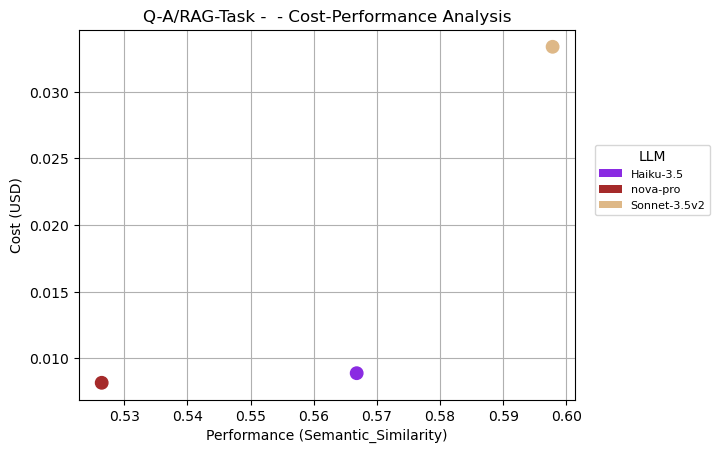

=== df_cp ===
 metric_name   Inference_Time  Input_Token  Output_Token  Throughput  \
Haiku-3.5             10.050       9343.0         356.0  102.312705   
nova-pro               4.152       9276.0         237.0  161.751557   
Sonnet-3.5v2          12.814       9343.0         356.0   79.961236   

metric_name   RougeL-sum  Semantic_Similarity   BERT-F1  Toxicity  \
Haiku-3.5       0.197698             0.566803  0.847664  0.000605   
nova-pro        0.229504             0.526428  0.836060  0.000590   
Sonnet-3.5v2    0.196039             0.597826  0.844705  0.000610   

metric_name   Answer_Correctness  Answer_similarity  Answer_Relevancy  \
Haiku-3.5                    NaN           0.744554               NaN   
nova-pro                     NaN           0.694010               NaN   
Sonnet-3.5v2                 NaN           0.745366               NaN   

metric_name   Context_Recall  Context_Precision      Cost  Cache_Input_Token  \
Haiku-3.5                NaN                NaN  0

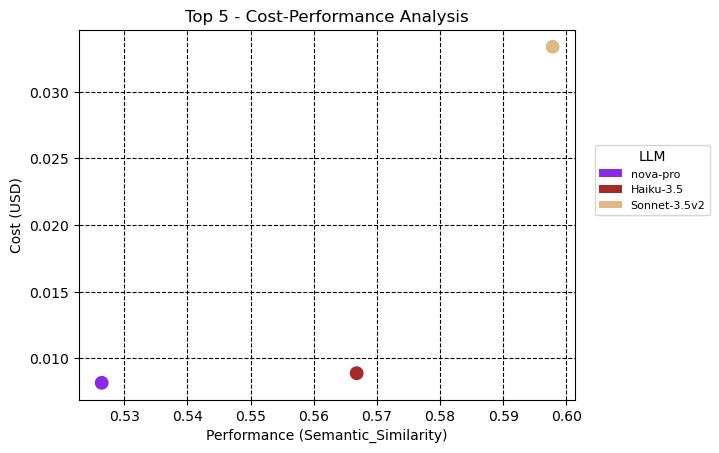

nova-pro        64.361760
Haiku-3.5       63.697198
Sonnet-3.5v2    17.915606
Name: cost_perf, dtype: float64

Uploading benchmark metrics ...
Uploading benchmark graphs ... :0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|
Uploading cost-performance graphs ... :
Benchmark output upload completed.


In [10]:
perf_metric = 'Semantic_Similarity'
top_x = 5

Ben_Save(Results_qa,S3_BUCKET,BENCH_KEY,TASK_FOLDER,perf_metric,top_x,'Q-A/RAG-Task')